<a href="https://colab.research.google.com/github/khmelkoff/TraxRuSummarizer/blob/main/TraxRuSummarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install trax

     |████████████████████████████████| 522kB 8.6MB/s 
     |████████████████████████████████| 215kB 15.1MB/s 
     |████████████████████████████████| 3.4MB 15.9MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
     |████████████████████████████████| 1.2MB 48.1MB/s 
     |████████████████████████████████| 3.8MB 49.9MB/s 
     |████████████████████████████████| 368kB 60.8MB/s 
     |████████████████████████████████| 1.8MB 42.6MB/s 
     |████████████████████████████████| 3.2MB 58.2MB/s 
     |████████████████████████████████| 890kB 55.5MB/s 


In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
# from unicodedata import normalize
# import sentencepiece as spm

import trax
from trax import layers as tl
from trax.supervised import decoding

%matplotlib inline

In [3]:
import textwrap
wrapper = textwrap.TextWrapper(width=70)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/lenta-ru-news.csv.zip')
data.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


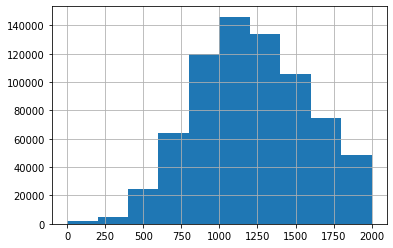

In [ ]:
data['text_len'] = [len(x) if not type(x)==float else 0 for x in data.text]
data.text_len[data.text_len < 2000].hist()

In [ ]:
text_full = []  # full text list for train senttence piece tokenizer
text_pairs = [] # paired data for train the model, format: (title, text)
for i in tqdm(range(data.shape[0])):
    if data.iloc[i, 6] >= 200 and data.iloc[i, 6] <= 2000:
        text_full.append(data.iloc[i, 1].lower() + '\n' + data.iloc[i, 2].lower())
        # list of (article, summary)
        text_pairs.append((data.iloc[i, 2].lower(), data.iloc[i, 1].lower()))

# save full text to text file for tokenizer training
with open('full_text.txt', 'w', encoding='utf-8') as file:
    file.write('\n'.join(text_full))  

100%|██████████| 800975/800975 [01:05<00:00, 12189.45it/s]


## Load / Train BPE tokenizer

In [26]:
# train tokenizer
spm.SentencePieceTrainer.train('--input=full_text.txt --pad_id=0 --bos_id=-1 --eos_id=1 --unk_id=2 \
                               --model_prefix=bpe --vocab_size=32000 --model_type=bpe')
sp = spm.SentencePieceProcessor()
sp.load('bpe.model')

In [27]:
s0 = text_pairs[10][0]
text_list = wrapper.wrap(s0[:300])
for line in text_list:
    print(line)

In [28]:
# tokenizer check
print('encode: text => id:')
print(sp.encode_as_pieces(s0[:300]))
print('')
print(sp.encode_as_ids(s0[:300]))
print('')
print('decode: id => text:')
print(sp.decode_pieces(sp.encode_as_pieces(s0[:300])))
print('')
print(f'Beginning of sentence id: {sp.bos_id()}')
print(f'Pad id: {sp.pad_id()}')
print(f'End of sentence id: {sp.eos_id()}')
print(f'Unknown id: {sp.unk_id()}')
print(f'Vocab size: {sp.vocab_size()}')      

In [29]:
# uid = 18298
# spiece = "\u2581Саха"
# unknown = "_НЕИЗВЕСТНОСТЬ_"

# # id <=> piece conversion
# print(f'SentencePiece for ID {uid}: {sp.id_to_piece(uid)}')
# print(f'ID for Sentence Piece {spiece}: {sp.piece_to_id(spiece)}')

# # returns 0 for unknown tokens (we can change the id for UNK)
# print(f'ID for unknown text {unknown}: {sp.piece_to_id(unknown)}')

In [30]:
# # vocab's head and tail test
# print('\nId\tSentP\tControl?')
# print('------------------------')
# for uid in range(7):
#     print(uid, sp.id_to_piece(uid), sp.is_control(uid), sep='\t')
    
# for uid in range(sp.vocab_size()-7,sp.vocab_size()):
#     print(uid, sp.id_to_piece(uid), sp.is_control(uid), sep='\t')

## Data: preprocess and create generators

In [5]:
# loading prepared set to save time
text_pairs = pd.read_csv('/content/drive/MyDrive/lenta.csv', sep=';')
text_pairs = [(x, y) for x, y in zip(text_pairs.article, text_pairs.summary)]
print(wrapper.fill(text_pairs[0][0]))
print(wrapper.fill(text_pairs[0][1]))

проведение нового раунда минских переговоров по ситуации на украине в
ближайшее время исключено. об этом, как сообщает тасс, заявил советник
главы службы безопасности украины (сбу) маркиян лубкивский. «минска-2
не будет. у нас есть минск-1 и те договоренности, которые нужно
выполнять», — сказал лубкивский в эфире телеканала "1+1", обвинив
ополченцев в нарушении прежних договоренностей. в четверг полномочный
представитель самопровозглашенной донецкой народной республики (днр)
на переговорах контактной группы в минске денис пушилин заявил, что
власти республики готовы к возобновлению минского процесса. при этом
он выразил недоумение относительно позиции киева, который, по его
мнению, «стремится к полному прекращению минского процесса, чтобы
отказаться от прямых контактов с республиками». в сентябре 2014 года в
минске состоялись две встречи контактной группы по украине. 20
сентября был принят меморандум по осуществлению режима прекращения
огня, состоящий из девяти пунктов. 5 сентября был 

In [6]:
# train/eval split
margin = int(len(text_pairs)*0.95)
train_text_pairs = text_pairs[:margin]
print('train cases: ', len(train_text_pairs))
eval_text_pairs = text_pairs[margin:]
print('eval cases: ', len(eval_text_pairs))

train cases:  686277
eval cases:  36120


In [7]:
print(wrapper.fill(train_text_pairs[0][0]))

проведение нового раунда минских переговоров по ситуации на украине в
ближайшее время исключено. об этом, как сообщает тасс, заявил советник
главы службы безопасности украины (сбу) маркиян лубкивский. «минска-2
не будет. у нас есть минск-1 и те договоренности, которые нужно
выполнять», — сказал лубкивский в эфире телеканала "1+1", обвинив
ополченцев в нарушении прежних договоренностей. в четверг полномочный
представитель самопровозглашенной донецкой народной республики (днр)
на переговорах контактной группы в минске денис пушилин заявил, что
власти республики готовы к возобновлению минского процесса. при этом
он выразил недоумение относительно позиции киева, который, по его
мнению, «стремится к полному прекращению минского процесса, чтобы
отказаться от прямых контактов с республиками». в сентябре 2014 года в
минске состоялись две встречи контактной группы по украине. 20
сентября был принят меморандум по осуществлению режима прекращения
огня, состоящий из девяти пунктов. 5 сентября был 

In [8]:
def data_generator(data, shuffle=True):
    '''
      Input: 
        data - list containing tuples (article, summary)
        shuffle - If True: shuffle the data order
      Output:
        a tuple containing 2 elements:
        article
        summary
    '''
    
    data_lng = len(data) # len(data)
    index_list = [*range(data_lng)] # Create a list with the ordered indexes of sample data

    if shuffle:
        random.shuffle(index_list) # re-shuffle the order
    
    index = 0 # Start with the first element
    while True:
        # Wrap the index each time that we reach the end of the list
        if index >= data_lng:
            index = 0
            if shuffle:
                random.shuffle(index_list) # re-shuffle the order
            
        sample = data[index_list[index]]
        index += 1
        yield(sample)

# create data streams
def train_data_stream():
    return data_generator(train_text_pairs, shuffle=True)

def eval_data_stream():
    return data_generator(eval_text_pairs, shuffle=True)        

In [9]:
PAD, EOS, UNK = 0, 1, 2

def detokenize(integers):
    s = trax.data.detokenize(
        integers,
        vocab_type='sentencepiece',
        vocab_file='bpe.model',
        vocab_dir='/content/drive/MyDrive/') # loading pre-prepared model to save time
    return wrapper.fill(s)


def tokenize(s):
    inputs =  next(trax.data.tokenize(
        iter([s]),
        vocab_type='sentencepiece',
        vocab_file='bpe.model',
        vocab_dir='/content/drive/MyDrive/'))
    
    return list(inputs) + [EOS]
 
    
vocab_size = trax.data.vocab_size(
    vocab_type='sentencepiece',
    vocab_file='bpe.model',
    vocab_dir='/content/drive/MyDrive/')

print('vocab size: ', vocab_size)

vocab size:  16000


In [12]:
# tokenized = tokenize('сведения о пассажирах на всех видах транспорта, где используются именные проездные билеты')
# print('tokenized:')
# print(tokenized)
# print('len=', len(tokenized))
# detokenized = detokenize(tokenized)
# print('detokenized:')
# print(detokenized)
# print('len=', len(detokenized.split()))

In [13]:
# Concatenate tokenized inputs and targets using 0 as separator.
def preprocess(stream):
    for (article, summary) in stream:
        joint = np.array(list(article) + [EOS, PAD] + list(summary) + [EOS])
        mask = [0] * (len(list(article)) + 2) + [1] * (len(list(summary)) + 1) 
        yield joint, joint, np.array(mask)

# You can combine a few data preprocessing steps into a pipeline like this.
input_pipeline = trax.data.Serial(
    # Tokenizes
    trax.data.Tokenize(vocab_type='sentencepiece',
                       vocab_dir='/content/drive/MyDrive/',
                       vocab_file='bpe.model'),
    # Uses function defined above
    preprocess,
    # trax.data.FilterByLength(2048)
)

# Apply preprocessing to data streams.
train_stream = input_pipeline(train_data_stream())
eval_stream = input_pipeline(eval_data_stream())

In [14]:
train_input, train_target, train_mask = next(train_stream)
# assert sum((train_input - train_target)**2) == 0  # They are the same in Language Model (LM).
# check pad (id:0) and sep/eos (id:1)
print(train_input[-20:])

[ 5022    16 12427  1749  8434  4981 15949     1     0  4380     4 12975
 14141     5  8369   200   191  6292  7151     1]


## Batching and Bucketing 

In [15]:
# batch of 8 sentences of length < 256 , 4 of length < 512....
boundaries =  [256, 512, 1024]
batch_sizes = [16, 8, 4, 2]

# Create the streams.
train_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes)(train_stream)

eval_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes)(eval_stream)

In [16]:
input_batch, _, mask_batch = next(train_batch_stream)

# Shape of the input_batch
input_batch.shape

(8, 512)

In [17]:
# check autopadding endig of sample
# 1, 0, <not 0 digit>... - end of article and start of summary
input_batch[0]

array([ 5172,     5,  5489,   846,    57,  1689,  1679,  8727,  2224,
        1280,     5,  1813,  5192,  1237,   315,  4572,  2617, 15945,
         939,  2328,  2371,  9806,  2346,  4011,  3399, 15932, 15020,
          25,   227,  2072,   730,  6686,   519,    86, 12175, 12344,
       15941,   771,    70,  3639,    86, 15960,    31, 11055,  3948,
        9996, 15945,   258,   110,  1234,   371, 13556,  3801,  6173,
          18,  5192,    25,  4600,  6373,   511,  5223,  2441,  1810,
          11,  2421,   212,  9996,  2617, 15949,   752,   150,  6042,
        2824,  6612,  1332,    57,   483, 15945,  2246,  3212,     5,
       12344,  2782,   130,  4274,  3567,  3573, 15949,     5,  6381,
        3487, 15945,    79,  5601,  8130,   442,  4257,   126, 15945,
           5,  2405,  1194,  5065,  4810,   166, 15945,  2351,    10,
       10761,  4318,   563,  7345,    75,  6847,   124,     5,  7386,
        1925, 12213,   218, 15945,  2085,  7930,    57,   483, 15949,
         505,  5172,

## Transformer Model

### Positional encoder

In [18]:
def PositionalEncoder(vocab_size, d_model, dropout, max_len, mode):
    """Returns a list of layers that: 
    1. takes a block of text as input, 
    2. embeds the words in that text, and 
    3. adds positional encoding, 
       i.e. associates a number in range(max_len) with 
       each word in each sentence of embedded input text 
    
    The input is a list of tokenized blocks of text
    
    Args:
        vocab_size (int): vocab size.
        d_model (int):  depth of embedding.
        dropout (float): dropout rate (how much to drop out).
        max_len (int): maximum symbol length for positional encoding.
        mode (str): 'train' or 'eval'.
    """
    # Embedding inputs and positional encoder
    return [ 
        # Add embedding layer of dimension (vocab_size, d_model)
        tl.Embedding(vocab_size, d_model),  
        # Use dropout with rate and mode specified
        tl.Dropout(rate=dropout, mode=mode), 
        # Add positional encoding layer with maximum input length and mode specified
        tl.PositionalEncoding(max_len=max_len, mode=mode)] 

### Feed-Forward layer

In [19]:
def FeedForward(d_model, d_ff, dropout, mode, ff_activation):
    """Returns a list of layers that implements a feed-forward block.

    The input is an activation tensor.

    Args:
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        dropout (float): dropout rate (how much to drop out).
        mode (str): 'train' or 'eval'.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        list: list of trax.layers.combinators.Serial that maps an activation tensor to an activation tensor.
    """
    
    # Feed-forward block (list) with two dense layers with dropout and input normalized
    return [ 
        # Normalize layer inputs
        tl.LayerNorm(), 
        # Add first feed forward (dense) layer
        tl.Dense(d_ff), 
        # Add activation function passed in as a parameter
        ff_activation(),  # ReLU
        # Add dropout with rate and mode specified (don't use dropout during evaluation)
        tl.Dropout(rate=dropout, mode=mode), 
        # Add second feed forward layer
        tl.Dense(d_model), 
        # Add dropout with rate and mode specified
        tl.Dropout(rate=dropout, mode=mode) 
    ]

### Decoder Block

In [20]:
def DecoderBlock(d_model, d_ff, n_heads,
                 dropout, mode, ff_activation):
    """Returns a list of layers that implements a Transformer decoder block.

    The input is an activation tensor.

    Args:
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        n_heads (int): number of attention heads.
        dropout (float): dropout rate (how much to drop out).
        mode (str): 'train' or 'eval'.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        list: list of trax.layers.combinators.Serial that maps an activation tensor to an activation tensor.
    """
        
    # List of two Residual blocks: the attention with normalization and dropout and feed-forward blocks
    return [
      tl.Residual(
          # Normalize layer input
          tl.LayerNorm(), 
          # Add causal attention 
          tl.CausalAttention(d_model, n_heads=n_heads, dropout=dropout, mode=mode) 
        ),
      tl.Residual(
          # Add feed-forward block
          # The feed-forward block takes care of normalization
          FeedForward(d_model, d_ff, dropout, mode, ff_activation)
        ),
      ]

### Trnsformer (decoder)

In [21]:
def SumTransformer(vocab_size=vocab_size,
                  d_model=512,
                  d_ff=2048,
                  n_layers=6,
                  n_heads=8,
                  dropout=0.1,
                  max_len=4096,
                  mode='train',
                  ff_activation=tl.Relu):
    """Returns a Transformer language model.

    The input to the model is a tensor of tokens. (This model uses only the
    decoder part of the overall Transformer.)

    Args:
        vocab_size (int): vocab size.
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        n_layers (int): number of decoder layers.
        n_heads (int): number of attention heads.
        dropout (float): dropout rate (how much to drop out).
        max_len (int): maximum symbol length for positional encoding.
        mode (str): 'train', 'eval' or 'predict', predict mode is for fast inference.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        trax.layers.combinators.Serial: A Transformer language model as a layer that maps from a tensor of tokens
        to activations over a vocab set.
    """
    
    # Stack of decoder blocks with n_layers with necessary parameters
    decoder_blocks = [ 
        DecoderBlock(d_model, d_ff, n_heads, dropout, mode, ff_activation) for _ in range(n_layers)] 

    # The complete model
    return tl.Serial(
        # Use teacher forcing (feed output of previous step to current step)
        tl.ShiftRight(mode=mode), 
        # Add embedding inputs and positional encoder
        PositionalEncoder(vocab_size, d_model, dropout, max_len, mode),
        # Add decoder blocks
        decoder_blocks, 
        # Normalize layer
        tl.LayerNorm(), 

        # Add dense layer of vocab_size (since need to select a word to translate to)
        # (a.k.a., logits layer. Note: activation already set by ff_activation)
        tl.Dense(vocab_size), 
        # Get probabilities with Logsoftmax
        tl.LogSoftmax() 
    )

In [22]:
print(SumTransformer(n_layers=1))

Serial[
  Serial[
    ShiftRight(1)
  ]
  Embedding_16000_512
  Dropout
  PositionalEncoding
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Serial[
          Serial[
            Serial[
              Branch_out3[
                [Dense_512, Serial[
                  SplitIntoHeads
                ]]
                [Dense_512, Serial[
                  SplitIntoHeads
                ]]
                [Dense_512, Serial[
                  SplitIntoHeads
                ]]
              ]
              DotProductCausalAttention_in3
              Serial[
                MergeHeads
              ]
              Dense_512
            ]
          ]
        ]
      ]
    ]
    Add_in2
  ]
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Dense_2048
        Serial[
          Relu
        ]
        Dropout
        Dense_512
        Dropout
      ]
    ]
    Add_in2
  ]
  LayerNorm
  Dense_16000
  LogSoftmax
]


## Training

In [23]:
from trax.supervised import training

def training_loop(SumTransformer, train_gen, eval_gen, output_dir = "~/model"):
    '''
    Input:
        SumTransformer (trax.layers.combinators.Serial): The transformer model.
        train_gen (generator): Training stream of data.
        eval_gen (generator): Evaluation stream of data.
        output_dir (str): folder to save your file.
        
    Returns:
        trax.supervised.training.Loop: Training loop.
    '''
    output_dir = os.path.expanduser(output_dir)  # trainer is an object

    # for initial train
    # lr_schedule = trax.lr.warmup(n_warmup_steps=4000, max_value=0.00015)
    # lr_schedule = trax.lr.warmup_and_rsqrt_decay(n_warmup_steps=8000, max_value=0.00015)
    
    # for re-train
    lr_schedule = trax.supervised.lr_schedules.constant(0.0001)

    train_task = training.TrainTask( 
      labeled_data=train_gen, # The training generator
      loss_layer=tl.CrossEntropyLoss(), # Loss function 
      optimizer=trax.optimizers.Adam(0.0001), # Optimizer 
      lr_schedule=lr_schedule,
      n_steps_per_checkpoint=100
    )

    eval_task = training.EvalTask( 
      labeled_data=eval_gen, 
      metrics=[tl.CrossEntropyLoss(), tl.Accuracy()] 
    )

    loop = training.Loop(SumTransformer(d_model=512,
                                       d_ff=2048,
                                       n_layers=6,
                                       n_heads=8,
                                       mode='train'),
                         train_task,
                         eval_tasks=[eval_task],
                         output_dir=output_dir)
    
    return loop

In [24]:
!cp /content/drive/MyDrive/model/model.pkl.gz ~/model/

In [25]:
# Should take around 1 minute per 100 step on GPU
# !rm -f ~/model/model.pkl.gz
loop = training_loop(SumTransformer, train_batch_stream, eval_batch_stream)
loop.run(20000)
!cp ~/model/model.pkl.gz /content/drive/MyDrive/model/


Step  200100: Ran 100 train steps in 72.92 secs
Step  200100: train CrossEntropyLoss |  3.49680829
Step  200100: eval  CrossEntropyLoss |  3.80252838
Step  200100: eval          Accuracy |  0.35514018

Step  200200: Ran 100 train steps in 35.47 secs
Step  200200: train CrossEntropyLoss |  3.39891481
Step  200200: eval  CrossEntropyLoss |  3.47128797
Step  200200: eval          Accuracy |  0.49532709

Step  200300: Ran 100 train steps in 52.42 secs
Step  200300: train CrossEntropyLoss |  3.30069256
Step  200300: eval  CrossEntropyLoss |  3.36671329
Step  200300: eval          Accuracy |  0.48999998

Step  200400: Ran 100 train steps in 35.49 secs
Step  200400: train CrossEntropyLoss |  3.37178683
Step  200400: eval  CrossEntropyLoss |  3.49869657
Step  200400: eval          Accuracy |  0.43203884

Step  200500: Ran 100 train steps in 35.61 secs
Step  200500: train CrossEntropyLoss |  3.21909213
Step  200500: eval  CrossEntropyLoss |  3.35392380
Step  200500: eval          Accuracy |  0

## Evaluate

### Predict next symbol (greedy)

In [31]:
# Get the model architecture
model = SumTransformer(mode='eval')

# Load the pre-trained weights
model.init_from_file('/root/model/model.pkl.gz', weights_only=True)

In [32]:
def next_symbol(cur_output_tokens, model):
    """Returns the next symbol for a given sentence.

    Args:
        cur_output_tokens (list): tokenized sentence with EOS and PAD tokens at the end.
        model (trax.layers.combinators.Serial): The transformer model.

    Returns:
        int: tokenized symbol.
    """

    token_length = len(cur_output_tokens)
    # calculate the minimum power of 2 big enough to store token_length
    padded_length = 2**int(np.ceil(np.log2(token_length + 1)))

    padded = list(cur_output_tokens) + [0] * (padded_length - token_length)
    padded_with_batch = np.array(padded)[None, :] # setting the batch dim

    output, _ = model((padded_with_batch, padded_with_batch)) 
    log_probs = output[0, token_length, :]
    
    return int(np.argmax(log_probs))

In [41]:
eval_article1 = eval_text_pairs[6][0]
eval_summary1 = eval_text_pairs[6][1]
print(wrapper.fill(eval_article1))
print('')
eval_article2 = eval_text_pairs[4][0]
eval_summary2 = eval_text_pairs[4][1]
print(wrapper.fill(eval_article2))
print('')
eval_article3 = eval_text_pairs[7][0]
eval_summary3 = eval_text_pairs[7][1]
print(wrapper.fill(eval_article3))

швейцарская часовая компания audemars piguet представила новую модель
из коллекции royal oak. как сообщает luxurylaunches, речь идет о часах
с вечным календарем. официальная презентация пройдет в рамках
международного салона высокого часового искусства sihh, который
проходит в женеве. часы выполнены из черной керамики с механизмом
калибра 5134. примерная стоимость часов составляет порядка 85 тысяч
долларов. audemars piguet специализируется на производстве люксовых
часов. компания была основана в 1875 году, ее штаб-квартира
располагается в женеве. с 1999 года фирма является официальным
спонсором скачек queen elizabeth ii cup, а также команды alinghi
sailing team по парусному спорту. среди знаменитостей, у кого есть
часы бренда: футболисты лионель месси и криштиану роналду, гонщики
михаэль шумахер и ярно трулли, а также актеры арнольд шварценеггер и
хью джекман.

американская general motors приняла решение отозвать свои
электромобили 1997-1998 года выпуска из-за неполадки, которая может


### Greedy decode

In [37]:
def greedy_decode(input_sentence, model):
    """Greedy decode function.

    Args:
        input_sentence (string): a sentence or article.
        model (trax.layers.combinators.Serial): Transformer model.

    Returns:
        string: summary of the input.
    """
    
    cur_output_tokens = tokenize(input_sentence) + [0]
    generated_output = [] 
    cur_output = 0 
    EOS = 1 
    
    while cur_output != EOS:

        print(detokenize(generated_output))
        cur_output = next_symbol(cur_output_tokens, model)
        cur_output_tokens.append(cur_output)
        generated_output.append(cur_output)

    return detokenize(generated_output)

In [38]:
print(eval_summary1)
print('')
_ = greedy_decode(eval_article1, model)

дом audemars piguet оснастил часы вечным календарем


a
au
aud
audem
audemars
audemars p
audemars pig
audemars pigu
audemars piguet
audemars piguet представила
audemars piguet представила часы


In [39]:
print(eval_summary2)
print('')
_ = greedy_decode(eval_article2, model)

general motors отзывает электромобили


gener
general
general mot
general motors
general motors отозва
general motors отозвала
general motors отозвала свои
general motors отозвала свои электро
general motors отозвала свои электромоби
general motors отозвала свои электромобили


In [42]:
print(eval_summary3)
print('')
_ = greedy_decode(eval_article3, model)

пекин потребовал от сша снять санкции с китайского банка


китай
китай пригрозил
китай пригрозил санк
китай пригрозил санкциями
китай пригрозил санкциями за
китай пригрозил санкциями за санкции
китай пригрозил санкциями за санкции против
китай пригрозил санкциями за санкции против банка
китай пригрозил санкциями за санкции против банка k
китай пригрозил санкциями за санкции против банка kun
китай пригрозил санкциями за санкции против банка kunl
китай пригрозил санкциями за санкции против банка kunlun


### Hystory generator

In [43]:
from IPython.display import clear_output

In [44]:
print(wrapper.fill(eval_article3[:300]+'...'), '\n')
print('Заголовок:', eval_summary3)

власти китая требуют отмены американских санкций в отношении банка
kunlun, которые были введены 31 июля. об этом сообщает "синьхуа" со
ссылкой на заявление пресс-секретаря мида кнр цинь ган (qin gang). во
вторник сша ввели новые экономические санкции в отношении нефтяных
компаний и цб ирана. америка... 

Заголовок: пекин потребовал от сша снять санкции с китайского банка


In [46]:
for s in range(20, 240, 20):
    model = SumTransformer(mode='eval')
    model.init_from_file('/content/drive/MyDrive/model/model' + str(s) + '.pkl.gz', weights_only=True)
    clear_output(wait=False)
    print('Эпоха: {0}, {1} шагов'.format(int(s/20), s*1000))
    _ = greedy_decode(eval_article3, model)    

Эпоха: 11, 220000 шагов

китай
китай пригрозил
китай пригрозил санк
китай пригрозил санкциями
китай пригрозил санкциями за
китай пригрозил санкциями за санкции
китай пригрозил санкциями за санкции против
китай пригрозил санкциями за санкции против банка
китай пригрозил санкциями за санкции против банка k
китай пригрозил санкциями за санкции против банка kun
китай пригрозил санкциями за санкции против банка kunl
китай пригрозил санкциями за санкции против банка kunlun
